---
title: "Flight Delays"
description: "Analyzing flight delays with PyMC"
author: "Mads Chr. Hansen"
date: "2023-10-08"
categories: [PyMC]
image: "https://images.unsplash.com/photo-1490430657723-4d607c1503fc?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2940&q=80"
format:
  html:
    code-fold: false
toc: true
---

In [19]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [ ]:
df = pd.read_csv("948363589_T_ONTIME_MARKETING.zip")

In [33]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,BRANDED_CODE_SHARE,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER,...,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,DUP,Unnamed: 60
0,2018,4,10,18,4,2018-10-18,UA,UA,19977,UA,...,6.0,6.0,0.0,0.0,1100-1159,0.0,NaN,0.0,N,NaN
1,2018,4,10,18,4,2018-10-18,UA,UA,19977,UA,...,-21.0,0.0,0.0,-2.0,2100-2159,0.0,NaN,0.0,N,NaN
2,2018,4,10,18,4,2018-10-18,UA,UA,19977,UA,...,10.0,10.0,0.0,0.0,1900-1959,0.0,NaN,0.0,N,NaN
3,2018,4,10,18,4,2018-10-18,UA,UA,19977,UA,...,-10.0,0.0,0.0,-1.0,0900-0959,0.0,NaN,0.0,N,NaN
4,2018,4,10,18,4,2018-10-18,UA,UA,19977,UA,...,-10.0,0.0,0.0,-1.0,1300-1359,0.0,NaN,0.0,N,NaN


Text(0.5, 0, 'Minutes late')

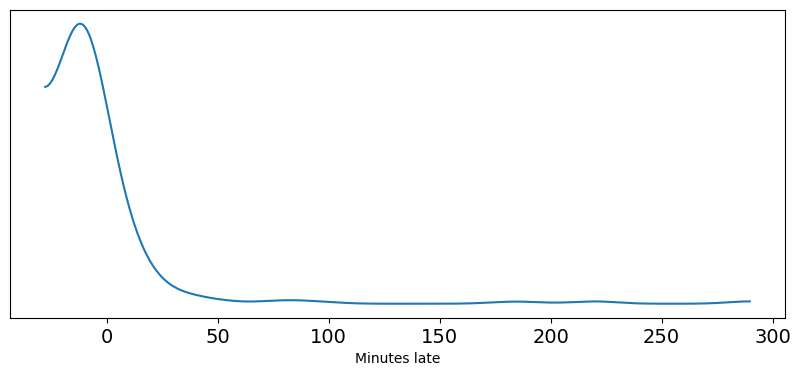

In [44]:
fig, ax = plt.subplots(figsize=(10,4))

msn_arrivals = df[(df["DEST"] == "MSN") & df["ORIGIN"].isin(["MSP", "DTW"])]["ARR_DELAY"]

az.plot_kde(msn_arrivals.values, ax=ax, bw=10)
ax.set_yticks([])
ax.set_xlabel("Minutes late")

In [45]:
#| code-fold: true

with pm.Model() as normal_model:
    normal_sd = pm.HalfStudentT("sd",sigma=60, nu=5)
    normal_mu = pm.Normal("mu", 0, 30) 

    normal_delay = pm.Normal("delays",mu=normal_mu,
                             sigma=normal_sd, observed=msn_arrivals)
    normal_prior_predictive = pm.sample_prior_predictive()
    
with pm.Model() as gumbel_model:
    gumbel_beta = pm.HalfStudentT("beta", sigma=60, nu=5)
    gumbel_mu = pm.Normal("mu", 0, 40)
    
    gumbel_delays = pm.Gumbel("delays",
                              mu=gumbel_mu,
                              beta=gumbel_beta,
                              observed=msn_arrivals)
    gumbel_prior_predictive = pm.sample_prior_predictive()

Sampling: [delays, mu, sd]
Sampling: [beta, delays, mu]


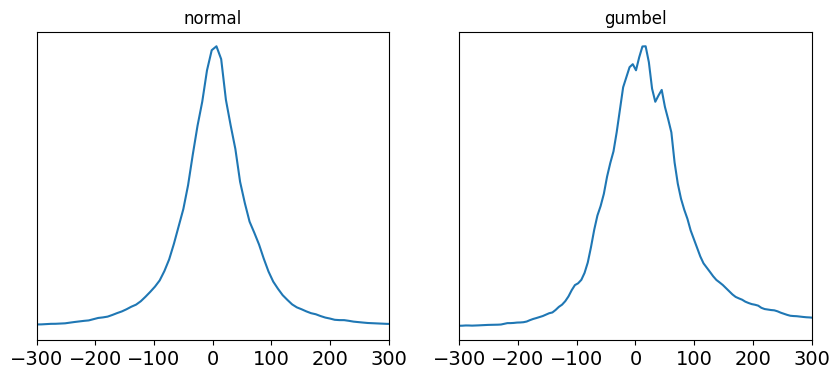

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

prior_predictives = {"normal":normal_prior_predictive.prior_predictive, "gumbel": gumbel_prior_predictive.prior_predictive}

for i, (label, prior_predictive) in enumerate(prior_predictives.items()):
    
    data = prior_predictive["delays"]
    az.plot_dist(data, ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xlim(-300, 300)
    axes[i].set_title(label)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'mu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sd'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

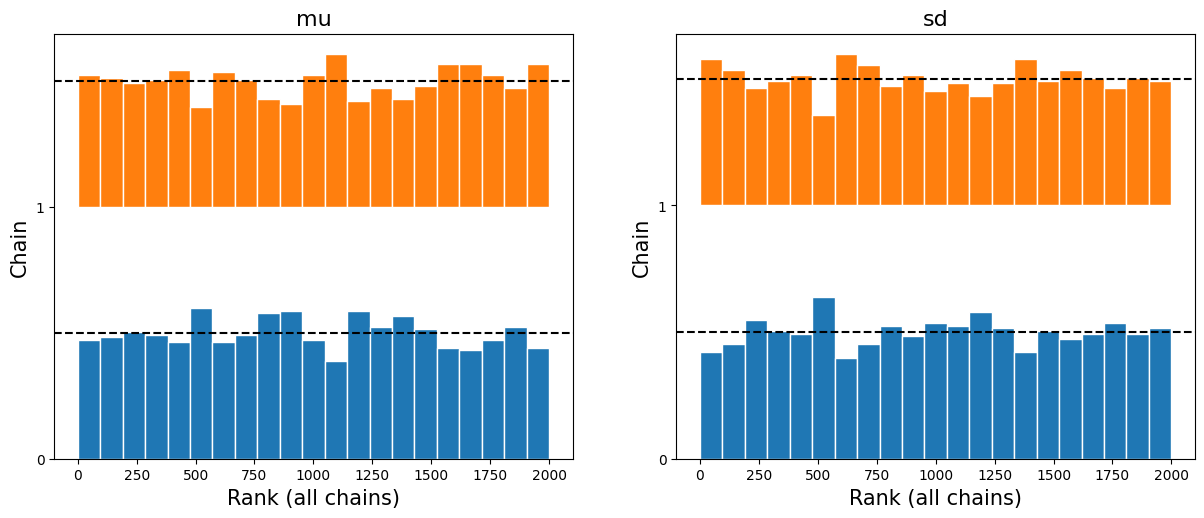

In [47]:
with normal_model:
    normal_delay_trace = pm.sample(random_seed=0, chains=2)
az.plot_rank(normal_delay_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'mu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

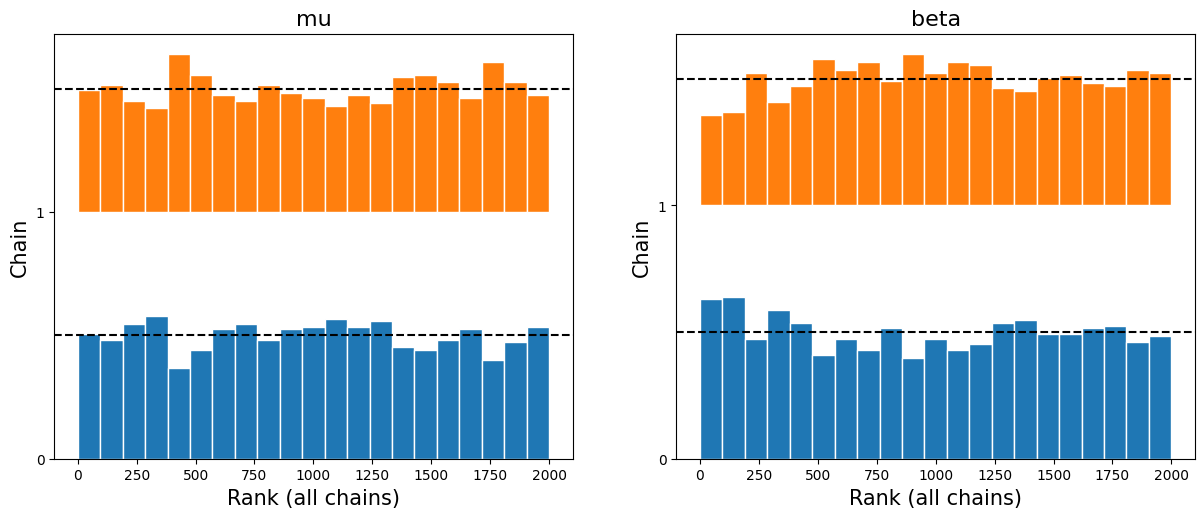

In [48]:
with gumbel_model:
    gumbel_delay_trace = pm.sample(chains=2)
az.plot_rank(gumbel_delay_trace)

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sd'}>],
      dtype=object)

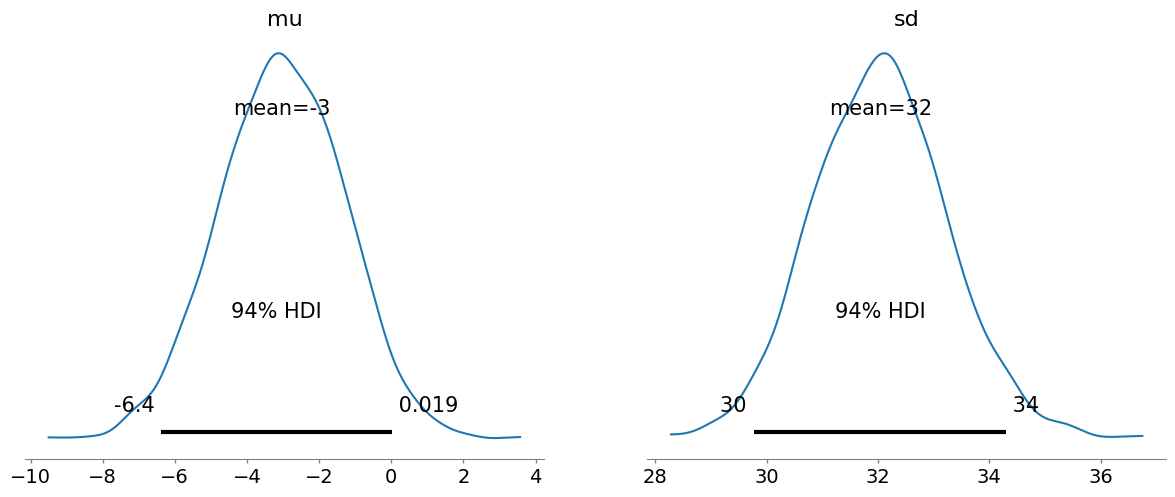

In [49]:
az.plot_posterior(normal_delay_trace)

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'beta'}>],
      dtype=object)

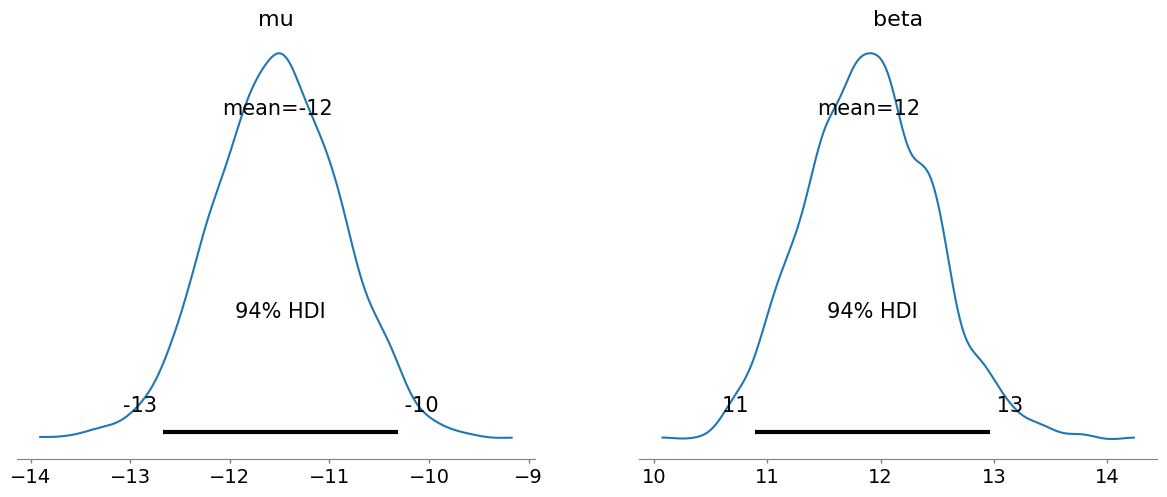

In [50]:
az.plot_posterior(gumbel_delay_trace)

In [51]:
with normal_model:
    normal_delay_trace = pm.sample(random_seed=0)
    pm.sample_posterior_predictive(normal_delay_trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [delays]


<Axes: xlabel='delays / delays'>

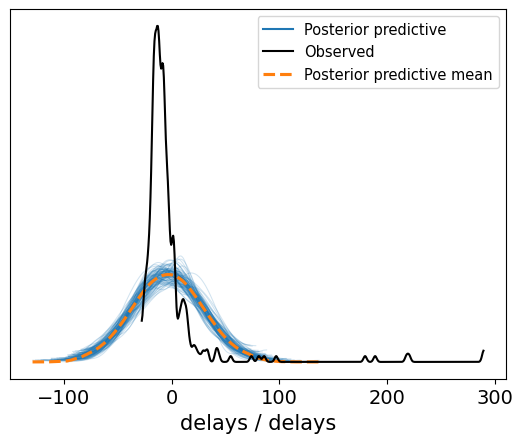

In [52]:
az.plot_ppc(normal_delay_trace, num_pp_samples=100)

In [53]:
with gumbel_model:
    gumbel_delay_trace = pm.sample(random_seed=0)
    pm.sample_posterior_predictive(gumbel_delay_trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Sampling: [delays]


<Axes: xlabel='delays / delays'>

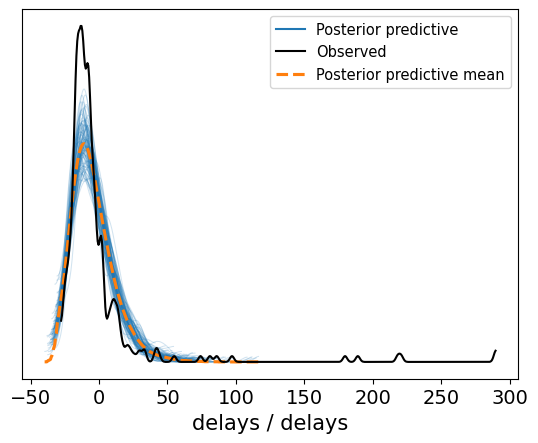

In [54]:
az.plot_ppc(gumbel_delay_trace, num_pp_samples=100)

In [56]:
gumbel_late = gumbel_delay_trace.posterior_predictive["delays"].values.reshape(-1, 336).copy()
dist_of_late = (gumbel_late > 0).sum(axis=1) / 336

percent_observed_late = (msn_arrivals > 0).sum() / 336

[]

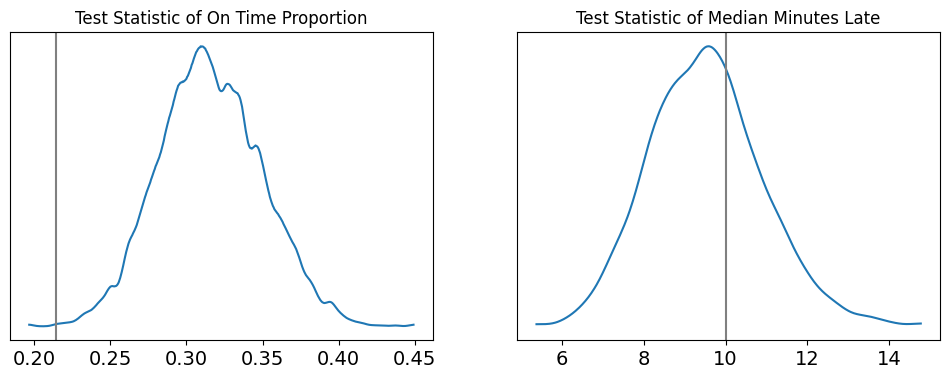

In [58]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
az.plot_dist(dist_of_late, ax=axes[0])


axes[0].axvline(percent_observed_late, c="gray")
axes[0].set_title("Test Statistic of On Time Proportion")
axes[0].set_yticks([])

gumbel_late[gumbel_late < 0] = np.nan
median_lateness = np.nanmedian(gumbel_late, axis=1)
az.plot_dist(median_lateness,  ax=axes[1])

median_time_observed_late = msn_arrivals[msn_arrivals >= 0].median()
axes[1].axvline(median_time_observed_late, c="gray")
axes[1].set_title("Test Statistic of Median Minutes Late")
axes[1].set_yticks([])

In [60]:
with normal_model:
    pm.compute_log_likelihood(normal_delay_trace)
    
with gumbel_model:
    pm.compute_log_likelihood(gumbel_delay_trace)

In [65]:
compare = az.compare({"normal": normal_delay_trace, "gumbel": gumbel_delay_trace}, ic="loo")
compare

/Users/madschr.hansen/Library/Caches/pypoetry/virtualenvs/pymc-experiment-7JkXVX9c-py3.11/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/madschr.hansen/Library/Caches/pypoetry/virtualenvs/pymc-experiment-7JkXVX9c-py3.11/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/madschr.hansen/Library/Caches/pypoetry/virtualenvs/pymc-experiment-7JkXVX9c-

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
gumbel,0,-1410.330975,5.866211,0.000000,1.000000e+00,45.179994,0.000000,False,log
normal,1,-1653.563218,21.263250,243.232243,1.609379e-09,65.204290,27.489639,True,log


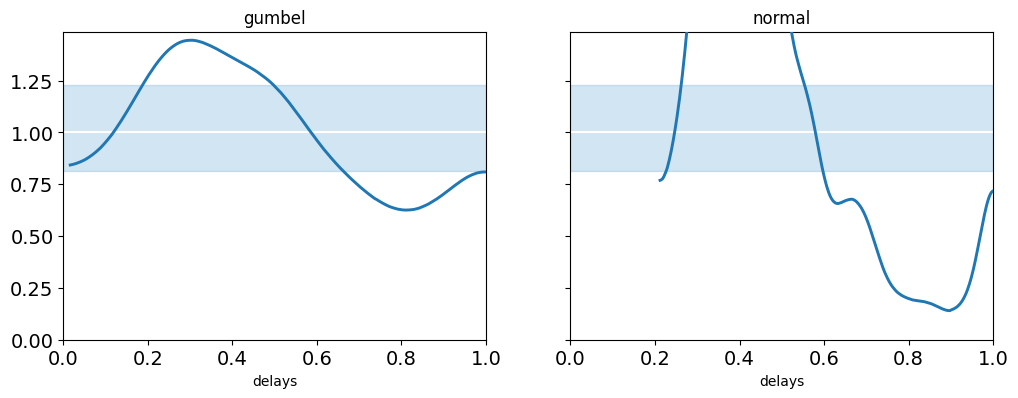

In [63]:
_, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for label, model, ax in zip(("gumbel", "normal"),(gumbel_delay_trace, normal_delay_trace), axes):
    az.plot_loo_pit(model, y="delays", legend=False, use_hdi=True, ax=ax)
    ax.set_title(label)

/Users/madschr.hansen/Library/Caches/pypoetry/virtualenvs/pymc-experiment-7JkXVX9c-py3.11/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


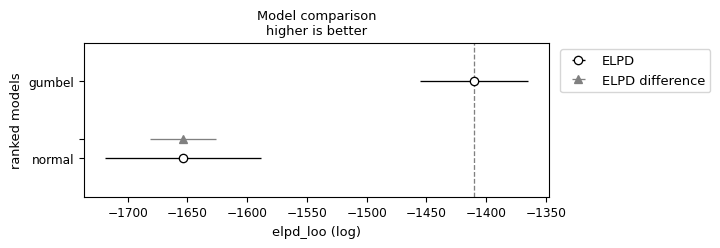

In [67]:
az.plot_compare(compare);

In [80]:
@np.vectorize
def current_revenue(delay):
    if delay >= 0:
        return 300 * delay
    return np.nan

In [81]:
posterior_pred = gumbel_delay_trace.posterior_predictive["delays"].values.reshape(-1, 336).copy()

In [82]:
def revenue_calculator(posterior_pred, revenue_func):    
    revenue_per_flight = revenue_func(posterior_pred)
    average_revenue = np.nanmean(revenue_per_flight)
    return revenue_per_flight, average_revenue

revenue_per_flight, average_revenue = revenue_calculator(posterior_pred,
current_revenue)
average_revenue

3929.7925096256663

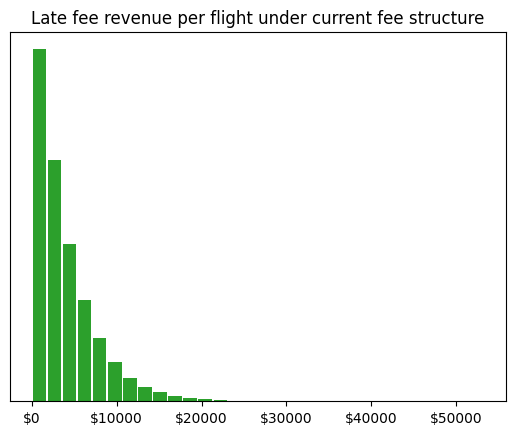

In [83]:
fig, ax = plt.subplots()
ax.hist(revenue_per_flight.flatten(), bins=30, rwidth=.9, color="C2" )
ax.set_yticks([])
ax.set_title("Late fee revenue per flight under current fee structure")
ax.xaxis.set_major_formatter('${x:1.0f}')

In [84]:
@np.vectorize
def proposed_revenue(delay):
    """Calculate proposed revenue for each delay """
    if delay >= 100:
        return 30000
    elif delay >= 10:
        return 5000
    elif delay >= 0:
        return 1000
    else:
        return np.nan
revenue_per_flight_proposed, average_revenue_proposed = revenue_calculator(posterior_pred, proposed_revenue)

In [85]:
average_revenue_proposed

2929.739994157172

[Text(0, 0, '$1000'), Text(1, 0, '$5000'), Text(2, 0, '$30000')]

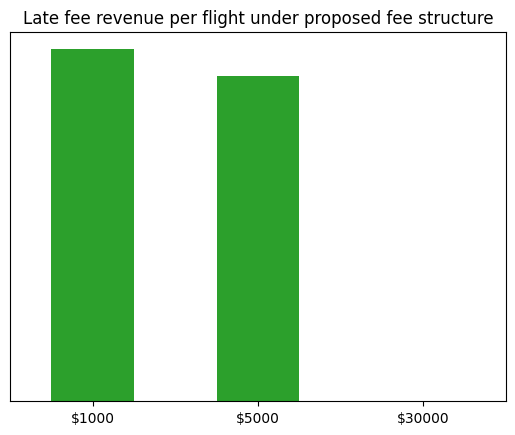

In [93]:
fig, ax = plt.subplots()

counts = pd.Series(revenue_per_flight_proposed.flatten()).value_counts()
counts.index = counts.index.astype(int)

counts.plot(kind="bar", ax=ax, color="C2")
ax.set_title("Late fee revenue per flight under proposed fee structure")
ax.set_yticks([]);
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xticklabels([f"${i}" for i in counts.index])

In [34]:
!quarto render flight_delays.ipynb --to html

pandoc 
  to: html
  output-file: flight_delays.html
  standalone: true
  section-divs: true
  html-math-method: mathjax
  wrap: none
  default-image-extension: png
  
metadata
  document-css: false
  link-citations: true
  date-format: long
  lang: en
  
Output created: flight_delays.html

